In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Path to the dataset
dataset_path = r"D:\SPOORTHI\Herlev DataSet\Processed_Data\filtered_images"
batch_size = 32
num_classes = 7  # Number of classes (7 directories)
num_epochs = 20  # Training epochs
learning_rate = 0.001

# Step 1: Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for SqueezeNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the entire dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Split into train and validation sets (80%, 20%)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # For validation

In [12]:
# Step 2: Define SqueezeNet Model
class CustomSqueezeNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomSqueezeNet, self).__init__()
        self.model = models.squeezenet1_1(pretrained=True)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)


# Instantiate model, optimizer, and loss function
model = CustomSqueezeNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
# Step 3: Combine Lévy Flight and Brownian Motion
def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    """
    Generate a step that combines Lévy flight and Brownian motion based on a given probability.
    """
    if np.random.rand() < prob_brownian:
        # Brownian motion: Small, incremental steps
        sigma_brownian = 0.1
        return np.random.normal(0, sigma_brownian, size)
    else:
        # Lévy flight: Long jumps based on Lévy distribution
        sigma_levy = (np.math.gamma(1 + lam) * np.sin(np.pi * lam / 2) /
                      (np.math.gamma((1 + lam) / 2) * lam * 2 ** ((lam - 1) / 2))) ** (1 / lam)
        u = np.random.normal(0, sigma_levy, size)
        v = np.random.normal(0, 1, size)
        return u / (np.abs(v) ** (1 / lam))

In [16]:
# Step 4: Implement Gazelle Optimizer with Lévy and Brownian
class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1, num_gazelles=10, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum, exploration_factor=exploration_factor, num_gazelles=num_gazelles)
        super(GazelleOptimizer, self).__init__(params, defaults)

        self.num_gazelles = num_gazelles
        self.gazelles = None
        self.prob_brownian = prob_brownian

    def initialize_population(self, param_shape):
        lb = -1.0
        ub = 1.0
        self.gazelles = torch.empty((self.num_gazelles, *param_shape), 
                                device='cuda' if torch.cuda.is_available() else 'cpu')
        self.gazelles.uniform_(lb, ub)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            momentum = group['momentum']
            lr = group['lr']
            exploration_factor = group['exploration_factor']
            num_gazelles = group['num_gazelles']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if self.gazelles is None or self.gazelles.shape[1:] != d_p.shape:
                    self.initialize_population(d_p.shape)

                # Exploration phase using combined Lévy flight and Brownian motion
                levy_brownian_step_vector = torch.tensor(
                    levy_brownian_step(prob_brownian=self.prob_brownian, size=d_p.numel()),
                    device=p.device,
                    dtype=p.dtype
                ).view_as(d_p)

                for i in range(num_gazelles):
                    self.gazelles[i] = (self.gazelles[i] + levy_brownian_step_vector * exploration_factor).clamp_(-1.0, 1.0)

                # Apply momentum and update
                if 'momentum_buffer' not in self.state[p]:
                    self.state[p]['momentum_buffer'] = torch.clone(d_p).detach()
                else:
                    buf = self.state[p]['momentum_buffer']
                    buf.mul_(momentum).add_(d_p)
                    d_p = buf

                # Update parameters with exploration and elite adjustment
                elite_gazelle = self.gazelles.mean(dim=0)
                p.data.add_(-lr, d_p + exploration_factor * elite_gazelle)

        return loss

In [18]:
# Step 5: Instantiate Optimizer
optimizer = GazelleOptimizer(model.parameters(), lr=0.001, momentum=0.9, exploration_factor=0.1, prob_brownian=0.3)

In [20]:
# Step 6: Define Loss and Training Loop
criterion = nn.CrossEntropyLoss()

In [22]:
# Step 3: Training Function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    train_loss_history = []
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_loss_history


# Step 4: Validation Function
def validate_model(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds


# Step 5: Fitness Function
def calculate_fitness(predictions, targets):
    """
    Calculate the fitness based on misclassification rate.
    Fitness = (Number of misclassified instances / Total instances) * 100
    """
    misclassified = np.sum(np.array(predictions) != np.array(targets))
    total_instances = len(targets)
    return (misclassified / total_instances) * 100

Training the model...


C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_7100\3513689406.py:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1 + lam) * np.sin(np.pi * lam / 2) /
C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_7100\3513689406.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + lam) / 2) * lam * 2 ** ((lam - 1) / 2))) ** (1 / lam)
C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_7100\550787645.py:57: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parse

Epoch [1/20], Loss: 1.7166
Epoch [2/20], Loss: 1.2369
Epoch [3/20], Loss: 1.0625
Epoch [4/20], Loss: 1.0229
Epoch [5/20], Loss: 0.9405
Epoch [6/20], Loss: 0.8876
Epoch [7/20], Loss: 0.8076
Epoch [8/20], Loss: 0.9280
Epoch [9/20], Loss: 0.8207
Epoch [10/20], Loss: 0.8218
Epoch [11/20], Loss: 0.6703
Epoch [12/20], Loss: 0.6494
Epoch [13/20], Loss: 0.5897
Epoch [14/20], Loss: 0.5663
Epoch [15/20], Loss: 0.6081
Epoch [16/20], Loss: 0.4901
Epoch [17/20], Loss: 0.5140
Epoch [18/20], Loss: 0.4173
Epoch [19/20], Loss: 0.3544
Epoch [20/20], Loss: 0.4360
Validating the model...
Fitness (Misclassification Rate): 34.78%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.77      0.64        22
           1       0.72      0.57      0.64        37
           2       0.46      0.57      0.51        28
           3       0.73      0.47      0.57        17
           4       0.82      0.93      0.88        15
           5       1.00      0.77   

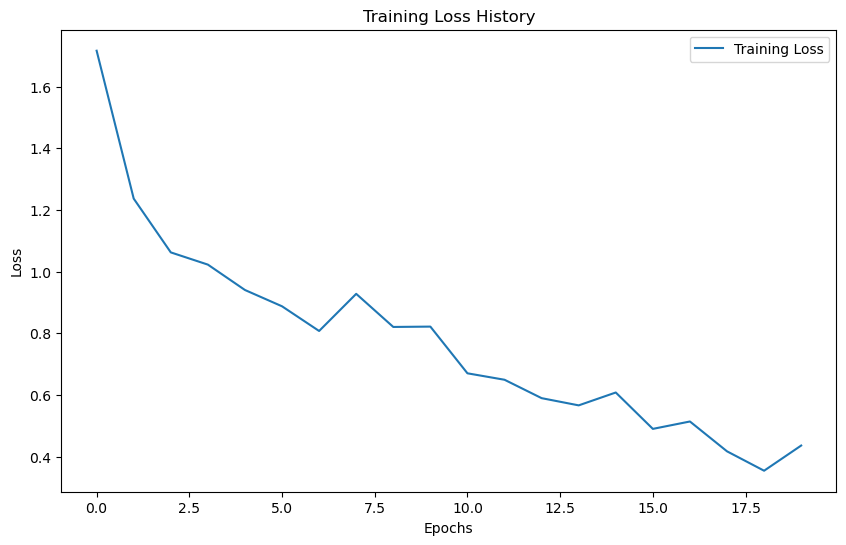

In [24]:
# Step 6: Train and Validate the Model
print("Training the model...")
train_loss_history = train_model(model, train_loader, criterion, optimizer, device, num_epochs)

print("Validating the model...")
true_labels, predicted_labels = validate_model(model, val_loader, device)

# Step 7: Evaluate Fitness and Metrics
fitness = calculate_fitness(predicted_labels, true_labels)
print(f"Fitness (Misclassification Rate): {fitness:.2f}%")

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

# Step 8: Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()


C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_7100\3513689406.py:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1 + lam) * np.sin(np.pi * lam / 2) /
C:\Users\Govindu Vijay Kumar\AppData\Local\Temp\ipykernel_7100\3513689406.py:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1 + lam) / 2) * lam * 2 ** ((lam - 1) / 2))) ** (1 / lam)


Epoch 1/20:
Train Loss: 0.3308, Train Acc: 0.8813
Val Loss: 0.9443, Val Acc: 0.6522
Epoch 2/20:
Train Loss: 0.2887, Train Acc: 0.9018
Val Loss: 0.9030, Val Acc: 0.6848
Epoch 3/20:
Train Loss: 0.3356, Train Acc: 0.8649
Val Loss: 1.0047, Val Acc: 0.7011
Epoch 4/20:
Train Loss: 0.2525, Train Acc: 0.9195
Val Loss: 1.0545, Val Acc: 0.6902
Epoch 5/20:
Train Loss: 0.2309, Train Acc: 0.9127
Val Loss: 1.1884, Val Acc: 0.6359
Epoch 6/20:
Train Loss: 0.2697, Train Acc: 0.9004
Val Loss: 1.2053, Val Acc: 0.6522
Epoch 7/20:
Train Loss: 0.2779, Train Acc: 0.8936
Val Loss: 1.2136, Val Acc: 0.6196
Epoch 8/20:
Train Loss: 0.3533, Train Acc: 0.8690
Val Loss: 1.0357, Val Acc: 0.6522
Epoch 9/20:
Train Loss: 0.2036, Train Acc: 0.9263
Val Loss: 1.2190, Val Acc: 0.6250
Epoch 10/20:
Train Loss: 0.1762, Train Acc: 0.9372
Val Loss: 1.2483, Val Acc: 0.5978
Epoch 11/20:
Train Loss: 0.1991, Train Acc: 0.9263
Val Loss: 1.1691, Val Acc: 0.6685
Epoch 12/20:
Train Loss: 0.2206, Train Acc: 0.9195
Val Loss: 1.0458, Val A

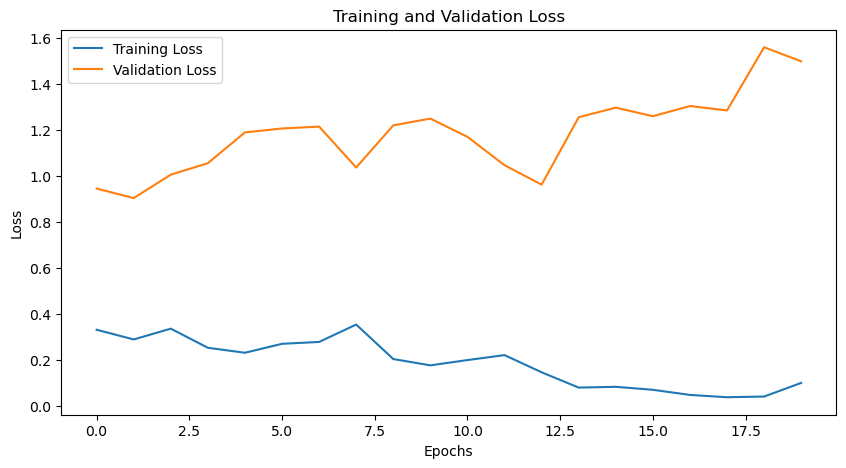

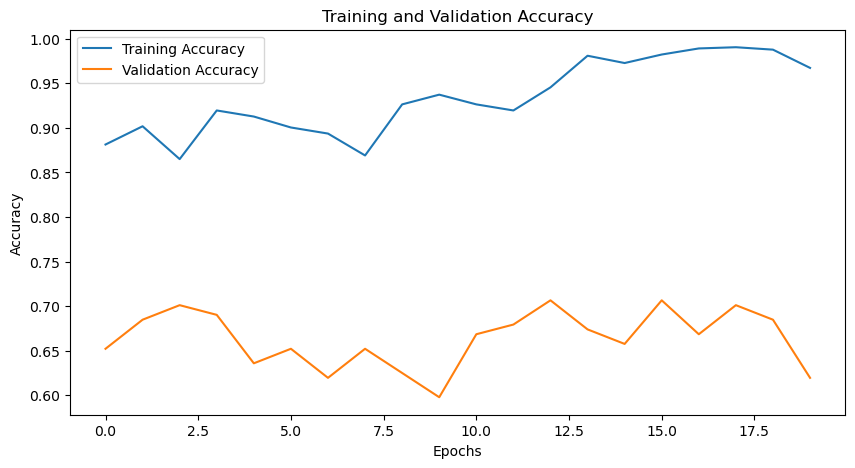

In [26]:
import matplotlib.pyplot as plt

# Variables to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(correct_train / total_train)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Accuracy: 0.6196
Precision: 0.6473
Recall: 0.6196
F1-Score: 0.6128
MCC: 0.5540


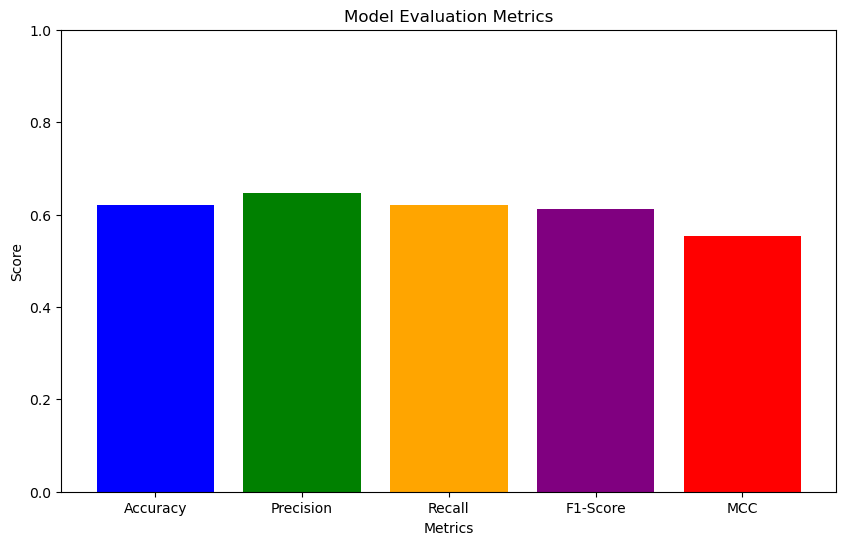

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
import matplotlib.pyplot as plt

# Initialize metrics for evaluation
accuracies = []
precisions = []
recalls = []
f1_scores = []
mcc_scores = []

# Evaluation Phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
mcc = matthews_corrcoef(all_labels, all_preds)

# Store Metrics
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
mcc_scores.append(mcc)

# Display Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

# Bar Graph Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
values = [accuracy, precision, recall, f1, mcc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.ylim(0, 1)  # Since metrics are between 0 and 1
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()



=== Training Metrics ===
Accuracy: 0.9413
Precision: 0.9452
Recall: 0.9413
F1-Score: 0.9408
MCC: 0.9310


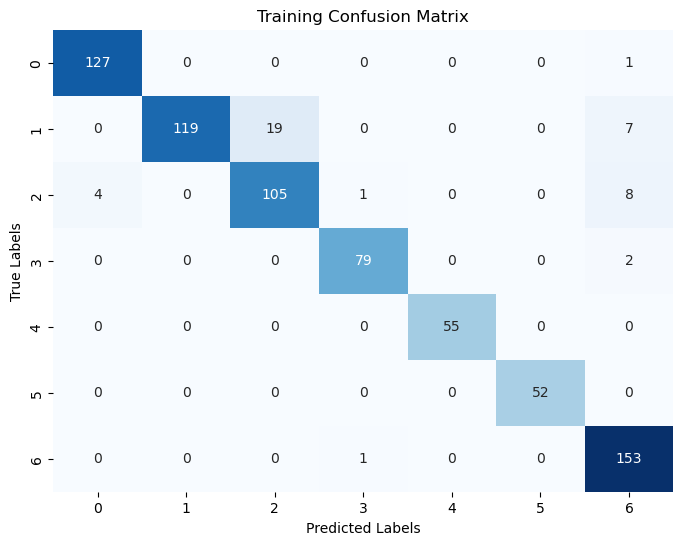


=== Validation Metrics ===
Accuracy: 0.6196
Precision: 0.6473
Recall: 0.6196
F1-Score: 0.6128
MCC: 0.5540


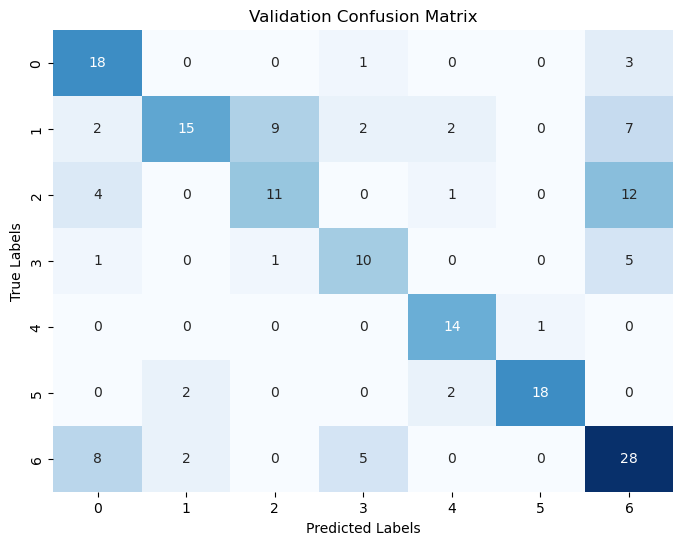

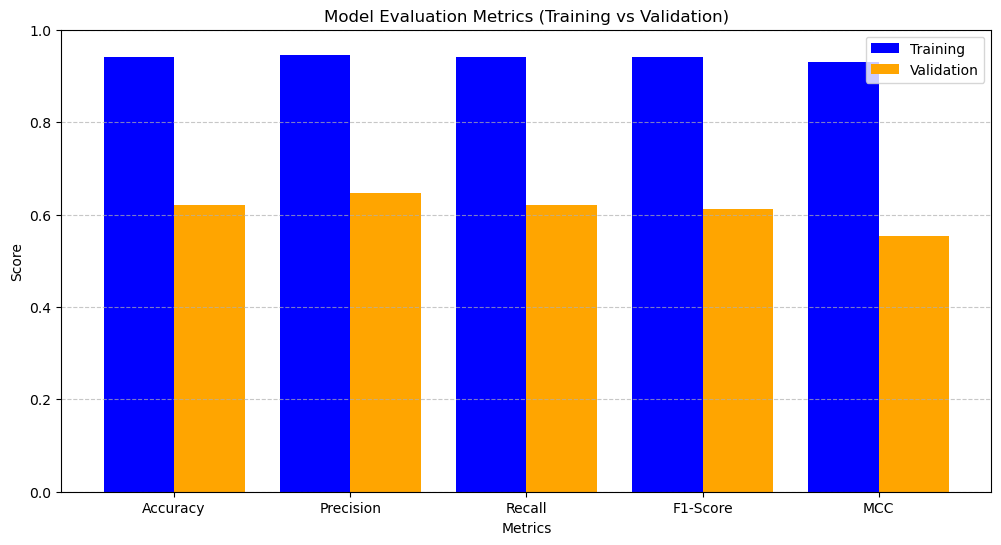

In [36]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, matthews_corrcoef,
    accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Function to calculate metrics and confusion matrix
def calculate_metrics_and_confusion_matrix(data_loader, dataset_type):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    mcc = matthews_corrcoef(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n=== {dataset_type} Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return [accuracy, precision, recall, f1, mcc]

# Evaluate both Training and Testing (Validation)
model.eval()
train_metrics = calculate_metrics_and_confusion_matrix(train_loader, "Training")
val_metrics = calculate_metrics_and_confusion_matrix(val_loader, "Validation")

# Bar Graph for Training vs Testing Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC']
x = range(len(metrics))

plt.figure(figsize=(12, 6))
bar_width = 0.4

# Training Metrics
plt.bar([i - bar_width / 2 for i in x], train_metrics, width=bar_width, label="Training", color="blue")

# Validation Metrics
plt.bar([i + bar_width / 2 for i in x], val_metrics, width=bar_width, label="Validation", color="orange")

# Plot settings
plt.ylim(0, 1)  # Metrics range between 0 and 1
plt.xticks(x, metrics)
plt.title("Model Evaluation Metrics (Training vs Validation)")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


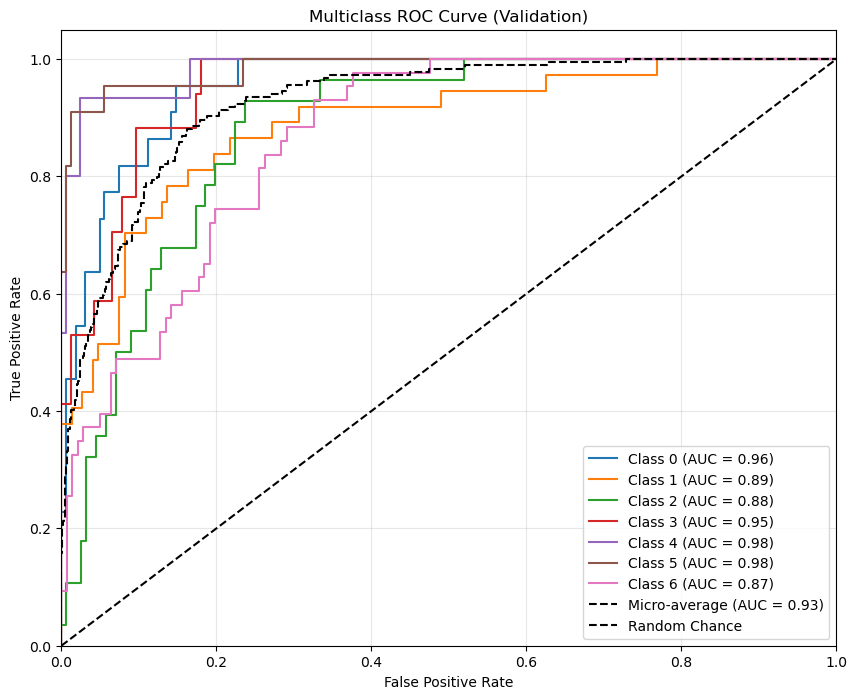

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_probs, num_classes, dataset_type):
    """
    Plot ROC curve for multiclass classification using one-vs-all approach.

    Parameters:
        y_true: True labels.
        y_probs: Predicted probabilities for each class.
        num_classes: Total number of classes.
        dataset_type: "Training" or "Validation".
    """
    # Binarize the labels for one-vs-all ROC computation
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))

    # Compute ROC curve and ROC area for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
        linestyle="--",
        color="black"
    )

    # Plot settings
    plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f"Multiclass ROC Curve ({dataset_type})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


# Get predicted probabilities for validation set
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Plot ROC curve for Validation
plot_multiclass_roc(all_labels, all_probs, num_classes=num_classes, dataset_type="Validation")


In [40]:
from PIL import Image

# Function to classify a single image
def classify_image(image_path, model, transform, class_names):
    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
    # Apply transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    # Move the tensor to the device (CPU or GPU)
    input_tensor = input_tensor.to(device)
    
    # Predict using the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)  # Get the index of the highest score
    
    # Get the class name
    predicted_label = class_names[predicted_class.item()]
    return predicted_label

# Path to the image to be classified
image_path = r"D:/SPOORTHI/Herlev DataSet/Processed_Data/filtered_images/severe_dysplastic/filtered_149056410-149056458-002.bmp"

# Predict the class
predicted_label = classify_image(image_path, model, transform, dataset.classes)

# Display the result
print(f"The image is classified as: {predicted_label}")

The image is classified as: severe_dysplastic


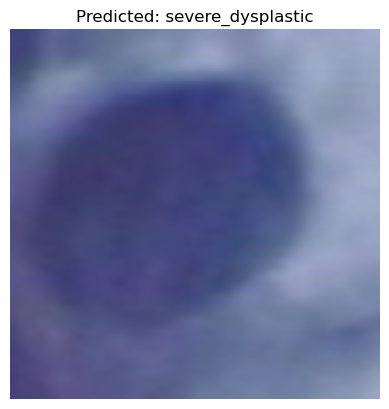

In [42]:
import matplotlib.pyplot as plt

# Display the image with the predicted label
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()